In [2]:
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv
import os
import time
import random
import math

%load_ext Cython

In [3]:
#v=list(os.walk('./zdjs/light_set'))
v=list(os.walk('./zdjs/pdfs'))

f=[0]*200
j=0
for i in range(0, len(v)):
    for x in (v[i][2]):
        f[j]=cv.imread(v[i][0]+'/'+x, cv.IMREAD_GRAYSCALE)
        j+=1
        
def grave(img, biw=0):
    fig, ax=plt.subplots(1,1,figsize=(22,22))
    if (biw==1):
        ax.imshow(img, cmap='Greys',  interpolation='nearest')
    else:
        ax.imshow(img)
    plt.show()
    return

def decorate(i):
    print()
    print('#'*30+'   '+str(i)+'   '+'#'*30)
    print()

In [4]:
%%cython
import numpy as np
import math
cimport numpy as np
from cpython cimport array
import array


def blackening(np.ndarray[unsigned char, ndim=2] bwimg, np.ndarray[long, ndim=2] path):
    cdef int s=0, t=0, gr=0, ij, i, jj
    cdef np.ndarray[int, ndim=1] dep=np.zeros((len(path)), dtype='int32')
    cdef np.ndarray[int, ndim=1] end1=np.zeros((len(path)), dtype='int32')
    cdef np.ndarray[int, ndim=1] end2=np.zeros((len(path)), dtype='int32')
    
    for i in range(0, len(path)):
        for ij in range(0, -10, -1):
            a, b=path[i,0]+ij, path[i,1]
            if (bwimg[a,b]==255):
                break
        end1[i]=ij
        
        for ij in range(1, 10, 1):
            a, b=path[i,0]+ij, path[i,1]
            
            if (bwimg[a,b]==255):
                break
        end2[i]=ij
        
        dep[i]=end2[i]-end1[i]
    
    #dep - jak długie jest pasmo w pionie, grub - grubość
    ld=len(dep)
    dep2=sorted(dep)
    small=dep2[math.floor(0.15*ld)]
    large=dep2[math.floor(0.85*ld)]
    
    dep2=dep2[math.floor(0.1*ld):math.floor(0.9*ld)]
    grub=sum(dep2)/len(dep2)-2
    #print('DEPTH {} {}'.format(grub, dep))
    
    #Midian - środkowy punkt pasma w punkcie
    midian=[0]*len(path)
    cur=0
    last=0
    midian[0]=path[0,0]
    for i in range(1, len(path)):
        if (dep[i]>grub+3):
            cur+=1
            continue
        else:
            midian[i]=path[i,0]+(end2[i]+end1[i])//2
            while (cur>0):
                p=path[i,0]-cur
                midian[i-cur]=midian[i] if (cur<p-last) else midian[last]
                tv=midian[i-cur]
                jj=1
                while (bwimg[tv, path[i-cur,1]]==255):
                    tv=tv+jj
                    jj=-jj-1*jj//abs(jj) 
                midian[i-cur]=tv
                cur-=1
            last=i
            
    #print(list(zip(path, midian)))
    dt0=math.ceil(grub)
    for i in range(len(path)):
        sc, t1, t2=0, 0, 0
        for jj in range(1, 10):
            if (bwimg[midian[i]+jj, path[i,1]]==255):
                break
        t1=jj
        for jj in range(0, -10, -1):
            if (bwimg[midian[i]+jj, path[i,1]]==255):
                break
        t2=jj
        sc=t1-t2
        
        if (sc<=dt0+2):
            for jj in range(t2, t1+1, 1):
                bwimg[midian[i]+jj, path[i,1]]=255
    c1=math.floor(0.1*len(midian))
    c2=math.floor(0.9*len(midian))
    
    return (sum(midian[c1:c2])/len(midian[c1:c2]), grub)


def cleanblack(bwimg, pathway):
    for x in pathway:
        bwimg[x[0]-5:x[0]+5,x[1]]=255
    return (1,2)

#limit - o ile y może się odchylić od y2
def pathfinder(np.ndarray[unsigned char, ndim=2] bwimg, F, np.ndarray[unsigned char, ndim=2] check, np.ndarray[int, ndim=1] par, np.ndarray[int, ndim=1] w, int y, int x, int p, int vv, int lowx, int highx, int y2, np.ndarray[int, ndim=1] miss, np.ndarray[int, ndim=1] added, np.ndarray[int, ndim=1] Vertikal):
    cdef int limit=10000, l2=6
    
    if (y>=bwimg.shape[0] or x>=bwimg.shape[1] or x<0 or y<0 or abs(y-y2)>limit):
        return (p, lowx, highx)
    if (check[y,x]==0 and (bwimg[y,x]==0 or miss[vv]<l2)):
        if (bwimg[y,x]==255):
            miss[p]=miss[vv]+1
        else:
            miss[p]=0
            #miss[p]=max(miss[vv]-2, 0)
        if (y>F[vv][0] or y<F[vv][0]):
            if (bwimg[y,x]==255):
                Vertikal[p]=Vertikal[vv]+2
            else:
                Vertikal[p]=Vertikal[vv]+1
        else:
            Vertikal[p]=max(Vertikal[vv]-1, 0)
        F.append((y, x))
        check[y,x]=1
        par[p]=vv
        if (bwimg[y,x]==0 and x<lowx):
            lowx=x
            added[p]=0
            w[p]=-1
        elif (bwimg[y,x]==0 and x>highx):
            highx=x
            w[p]=1
            added[p]=0
        else:
            w[p]=0
            added[p]=added[vv]+1
        return (p+1, lowx, highx)
    return (p, lowx, highx)


def findlinez(np.ndarray[unsigned char, ndim=2] bwimg, shp):
    cdef int skv=2, y=1, kk=1, iF=0, jF=1, deadl=0, deadr=1, highx, lowx, x1, x2, C=140000, myconst=70
    cdef int Vertikalpenalty=3
    solution=[]
    cdef np.ndarray[unsigned char, ndim=2] check=np.zeros((bwimg.shape[0], bwimg.shape[1]), dtype='uint8')
    cdef np.ndarray[int, ndim=1] par=np.zeros((C), dtype='int32')
    cdef np.ndarray[int, ndim=1] miss=np.zeros((C), dtype='int32')
    cdef np.ndarray[int, ndim=1] w=np.zeros((C), dtype='int32')
    cdef np.ndarray[int, ndim=1] added=np.zeros((C), dtype='int32')
    cdef np.ndarray[int, ndim=1] Vertikal=np.zeros((C), dtype='int32')
    
    for kk in range(1, skv):
        y=1
        x1=(kk*bwimg.shape[1])//skv-2
        x2=(kk*bwimg.shape[1])//skv+2
        while (y<bwimg.shape[0]-1):
            vs=bwimg[y,x1:x2+1]
            if (0 in vs):
                xl=kk*(bwimg.shape[1]//skv)
                yl=y
                
                pathway=[]
                F=[(yl, xl)]
                par[0]=-1
                w[0]=0
                miss[0]=0
                Vertikal[0]=0
                
                highx, lowx=xl, xl
                iF, jF=0, 1
                while(iF<jF):
                    if (added[iF]>=myconst or Vertikal[iF]>Vertikalpenalty):
                        #check[F[iF][0], F[iF][1]]=0
                        iF+=1
                        continue
                    
                    s=F[iF]
                    jF, lowx, highx=pathfinder(bwimg, F, check, par, w, s[0]-1, s[1], jF, iF, lowx, highx, y, miss, added, Vertikal)
                    jF, lowx, highx=pathfinder(bwimg, F, check, par, w, s[0]+1, s[1], jF, iF, lowx, highx, y, miss, added, Vertikal)
                    jF, lowx, highx=pathfinder(bwimg, F, check, par, w, s[0], s[1]-1, jF, iF, lowx, highx, y, miss, added, Vertikal)
                    jF, lowx, highx=pathfinder(bwimg, F, check, par, w, s[0], s[1]+1, jF, iF, lowx, highx, y, miss, added, Vertikal)
                    iF+=1
                #print(y, jF, lowx, highx)
                #print('PedE', pointdead, jF, highx, lowx)
                for j1 in range(jF-1, -1, -1):
                    if (w[j1]==-1 and bwimg[F[j1][0], F[j1][1]]==0):
                        break
                while (j1>=0):
                    pathway.append(F[j1])
                    j1=par[j1]
                
                for j2 in range(jF-1, -1, -1):
                    if (w[j2]==1 and bwimg[F[j2][0], F[j2][1]]==0):
                        break
                
                p2=[]
                while (j2>0):
                    p2.append(F[j2])
                    j2=par[j2]
                
                pathway.extend(p2[::-1])
                for x in F:
                    check[x[0], x[1]]=0
                if (highx-lowx>shp[1]*0.25):
                    sv, gr=blackening(bwimg, np.asarray(pathway))
                    #sv, gr=cleanblack(bwimg, pathway)
                    solution.append((sv, gr, lowx, highx, pathway))
            y+=1
    return solution


##############################   0   ##############################



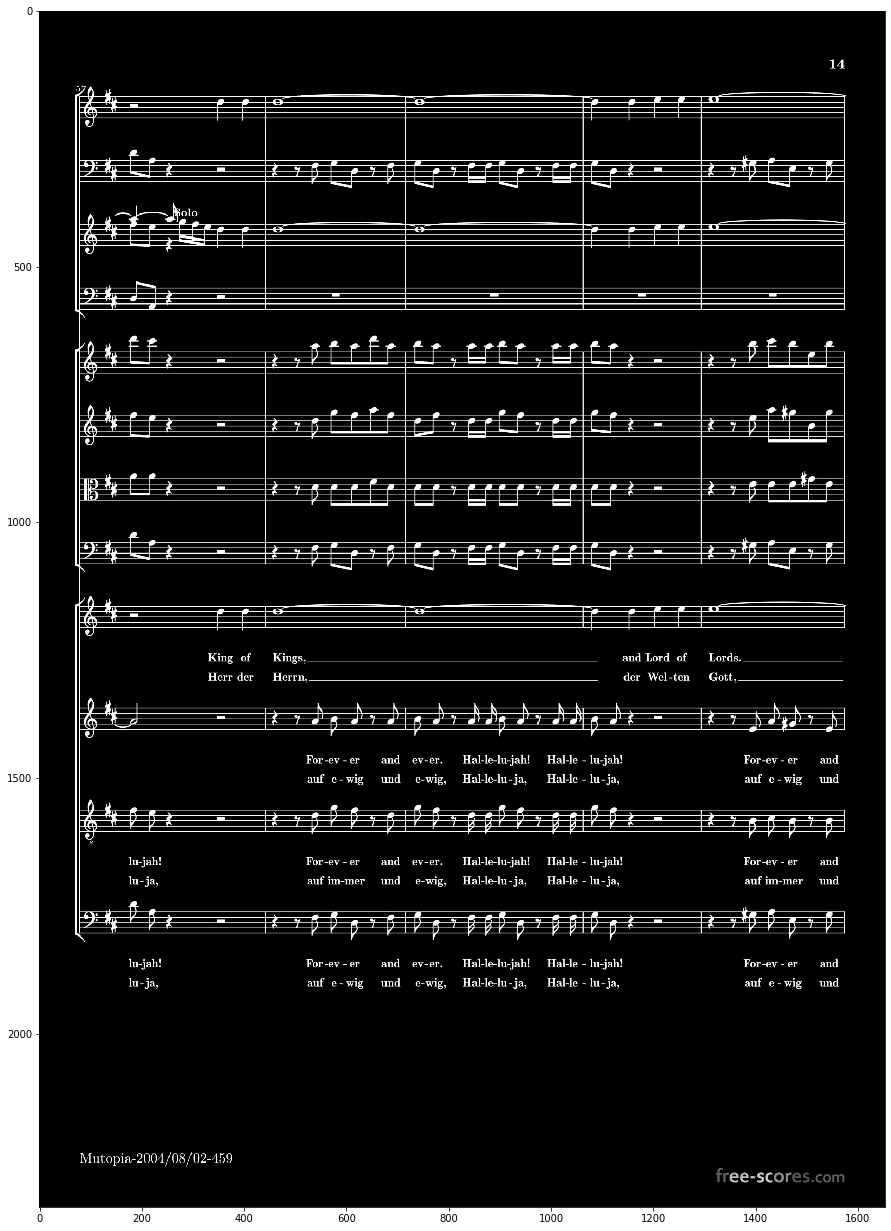

-0.08 13.038404810405298
-0.05 21.02379604162864
-0.04 30.01666203960727
-0.03 41.012193308819754
-0.02 115.0173913040496
0.0 62692.0
0.01 113.01769911471868
0.04 20.024984394500787
0.99 14.035668847618199
1.0 706.0
2339 1653 0.0 0.0


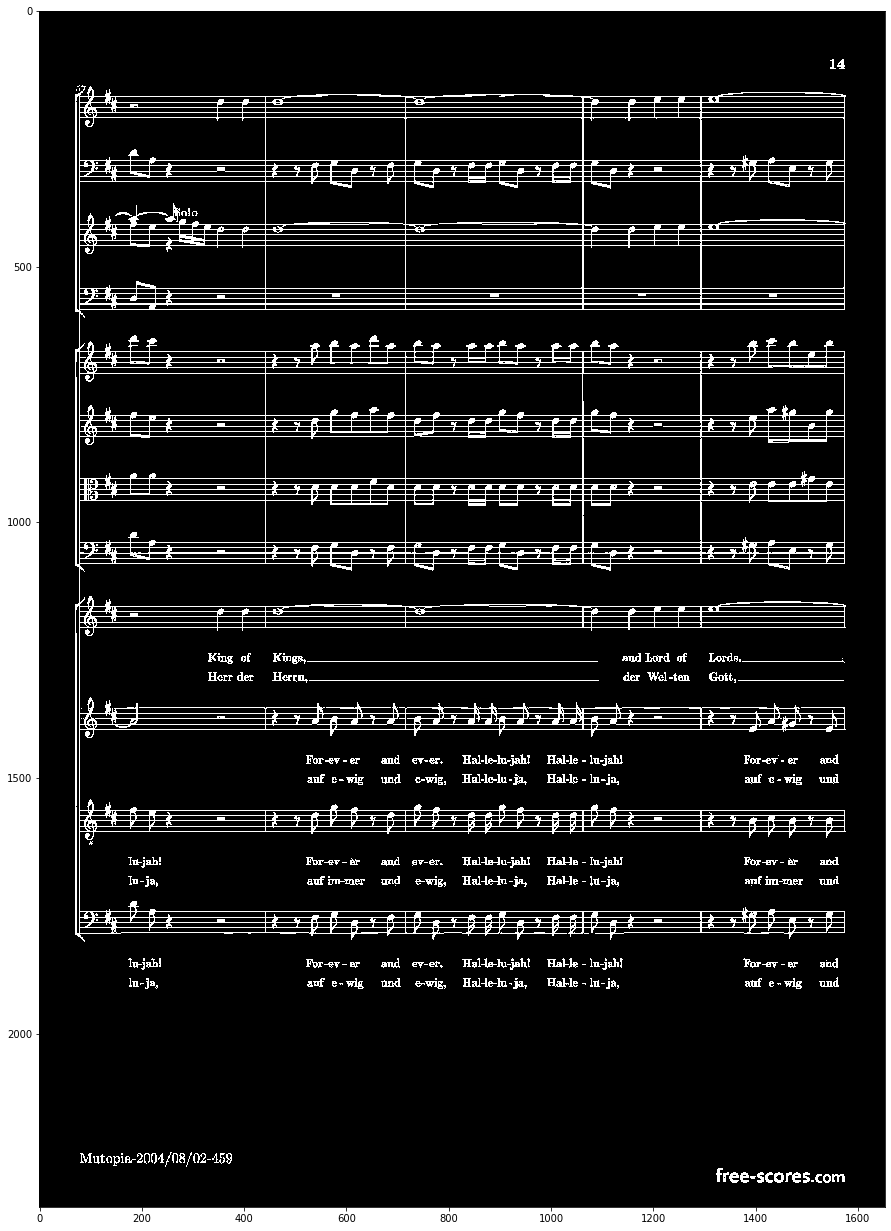

kolejno: [xbl, xbr], [ybl, ybr], [xel, xer], [yel, yer]
x - ixowa, y - ygrekowa, b - 1. linia, e - ostatnia linia, l - lewo, r - prawo
([81, 1587], [178.0, 177.0], [81, 1584], [218.0, 218.0])
([81, 1584], [301.0, 301.0], [81, 1584], [343.0, 343.0])
([81, 1586], [426.0, 426.0], [81, 1584], [468.0, 468.0])
([81, 1584], [551.0, 551.0], [81, 1584], [592.0, 592.0])
([81, 1585], [675.0, 675.75], [81, 1584], [717.0, 717.0])
([81, 1584], [800.0, 800.0], [81, 1584], [841.0, 841.0])
([81, 1584], [924.0, 924.0], [81, 1584], [966.0, 966.0])
([81, 1584], [1049.0, 1049.0], [81, 1584], [1090.0, 1085.3])
([81, 1586], [1173.0, 1173.0], [81, 1585], [1215.0, 1215.0])
([81, 1585], [1373.0, 1373.0], [81, 1585], [1414.0, 1414.75])
([81, 1585], [1572.0, 1572.0], [81, 1585], [1613.0, 1613.75])
([81, 1584], [1771.0, 1771.0], [81, 1584], [1813.0, 1807.3])
liczba liń z pięcioliń: 64 (jak podzielna przez 5 to pewnie się zgadza)


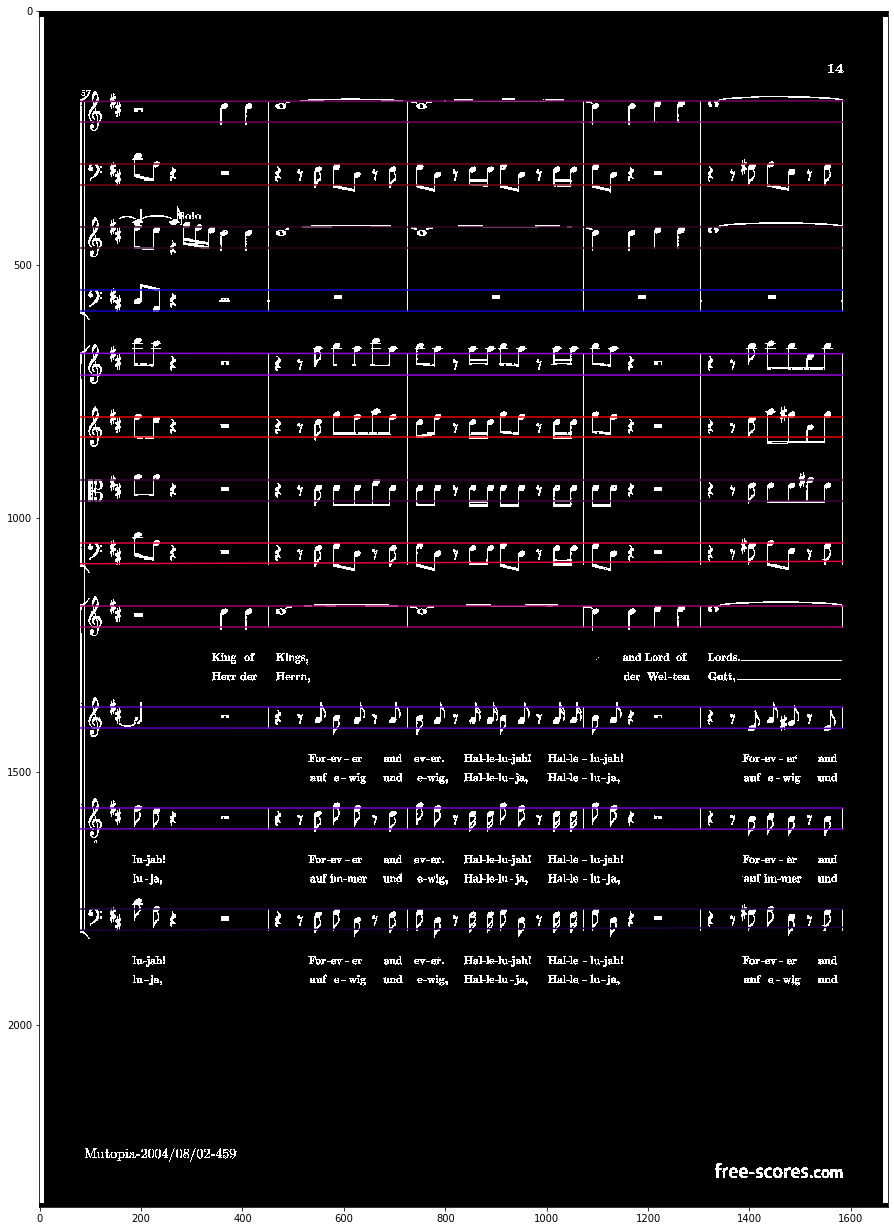

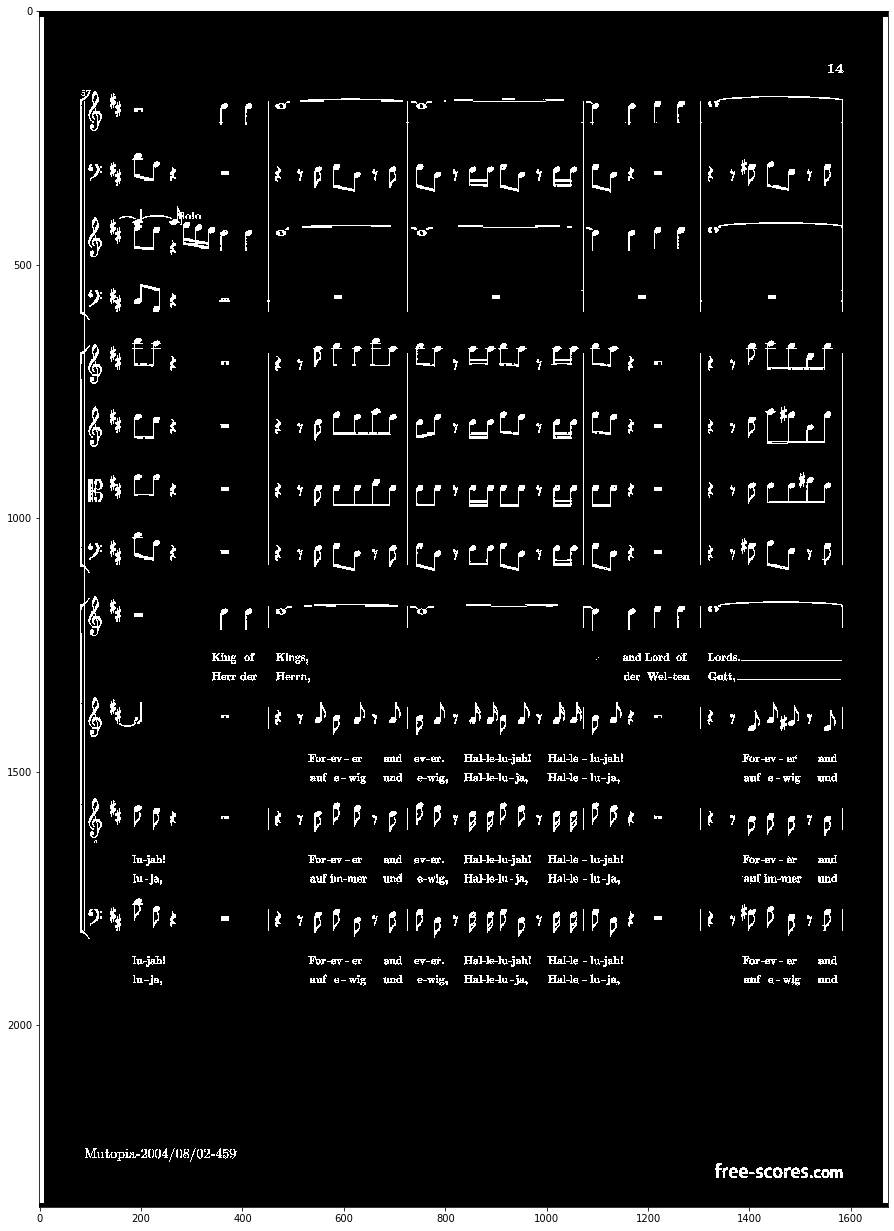

10.292130708694458

##############################   1   ##############################



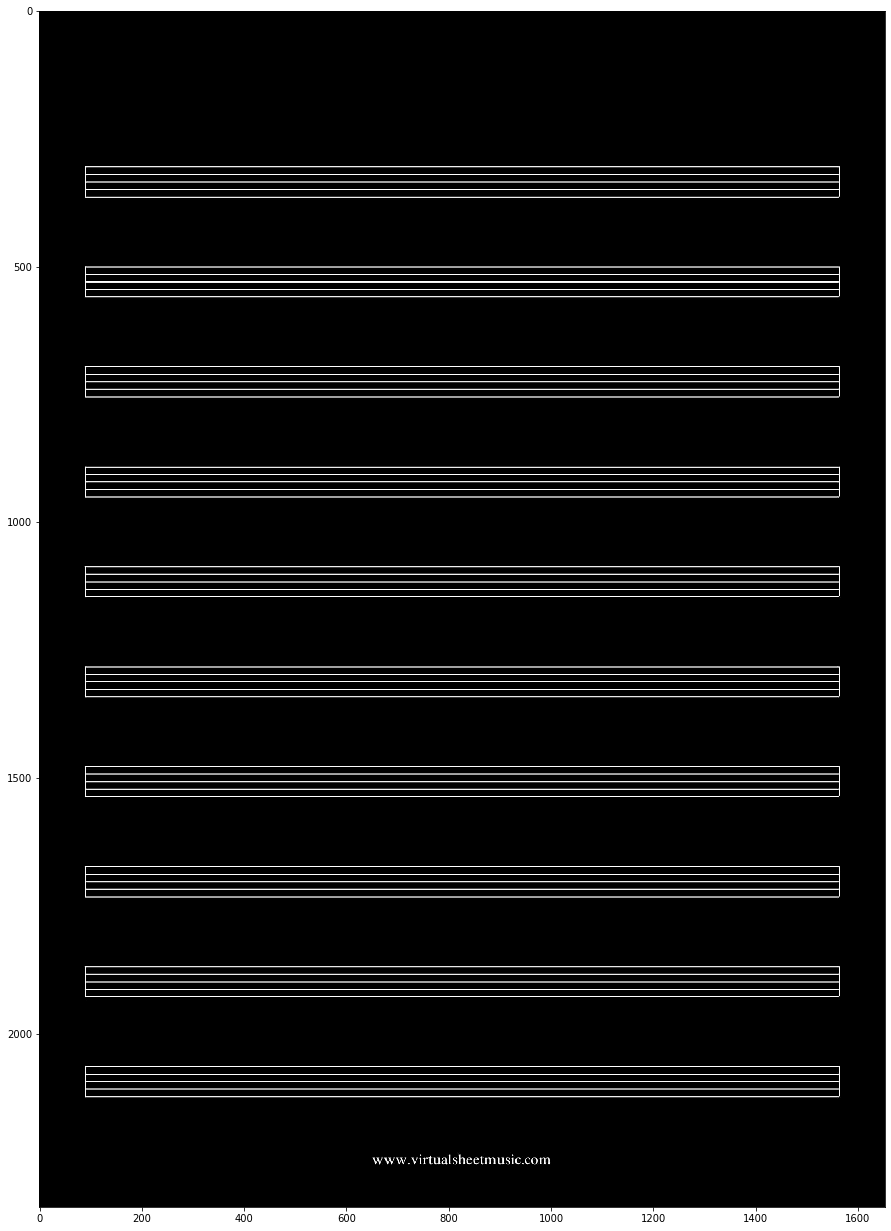

0.0 147016.0
2339 1653 0.0 0.0


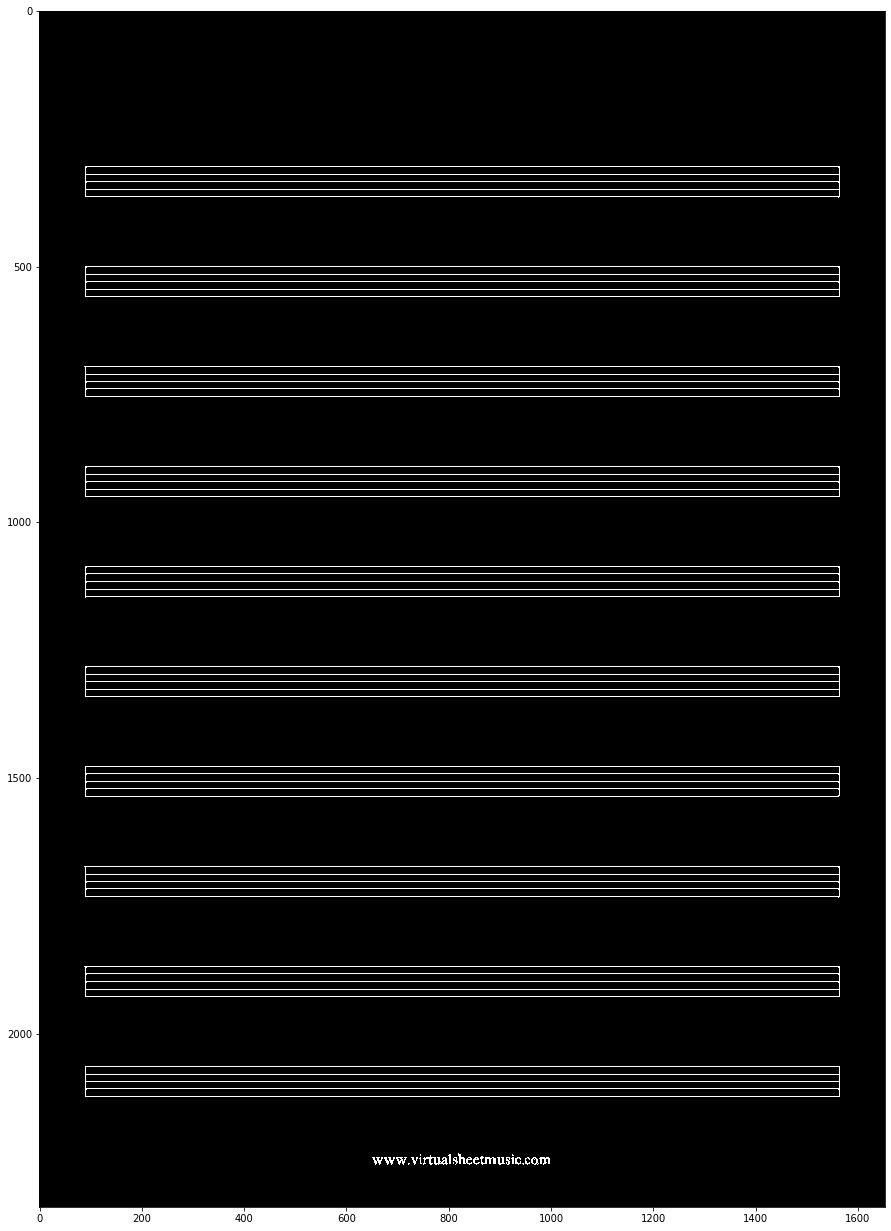

kolejno: [xbl, xbr], [ybl, ybr], [xel, xer], [yel, yer]
x - ixowa, y - ygrekowa, b - 1. linia, e - ostatnia linia, l - lewo, r - prawo
([100, 1575], [314.0, 314.0], [100, 1577], [372.0, 372.65])
([99, 1575], [509.475, 509.0], [100, 1575], [568.0, 568.0])
([99, 1575], [704.475, 704.0], [100, 1575], [763.0, 763.0])
([99, 1575], [900.475, 900.5], [100, 1575], [959.0, 959.0])
([100, 1575], [1096.0, 1096.5], [100, 1575], [1154.0, 1154.0])
([99, 1577], [1291.475, 1291.0], [99, 1575], [1350.475, 1350.0])
([100, 1575], [1486.0, 1486.5], [100, 1575], [1545.0, 1545.0])
([99, 1575], [1682.475, 1682.5], [100, 1575], [1741.0, 1741.0])
([99, 1575], [1878.0, 1878.0], [99, 1575], [1936.5, 1936.0])
([100, 1575], [2073.0, 2073.5], [100, 1575], [2132.0, 2132.0])
liczba liń z pięcioliń: 52 (jak podzielna przez 5 to pewnie się zgadza)


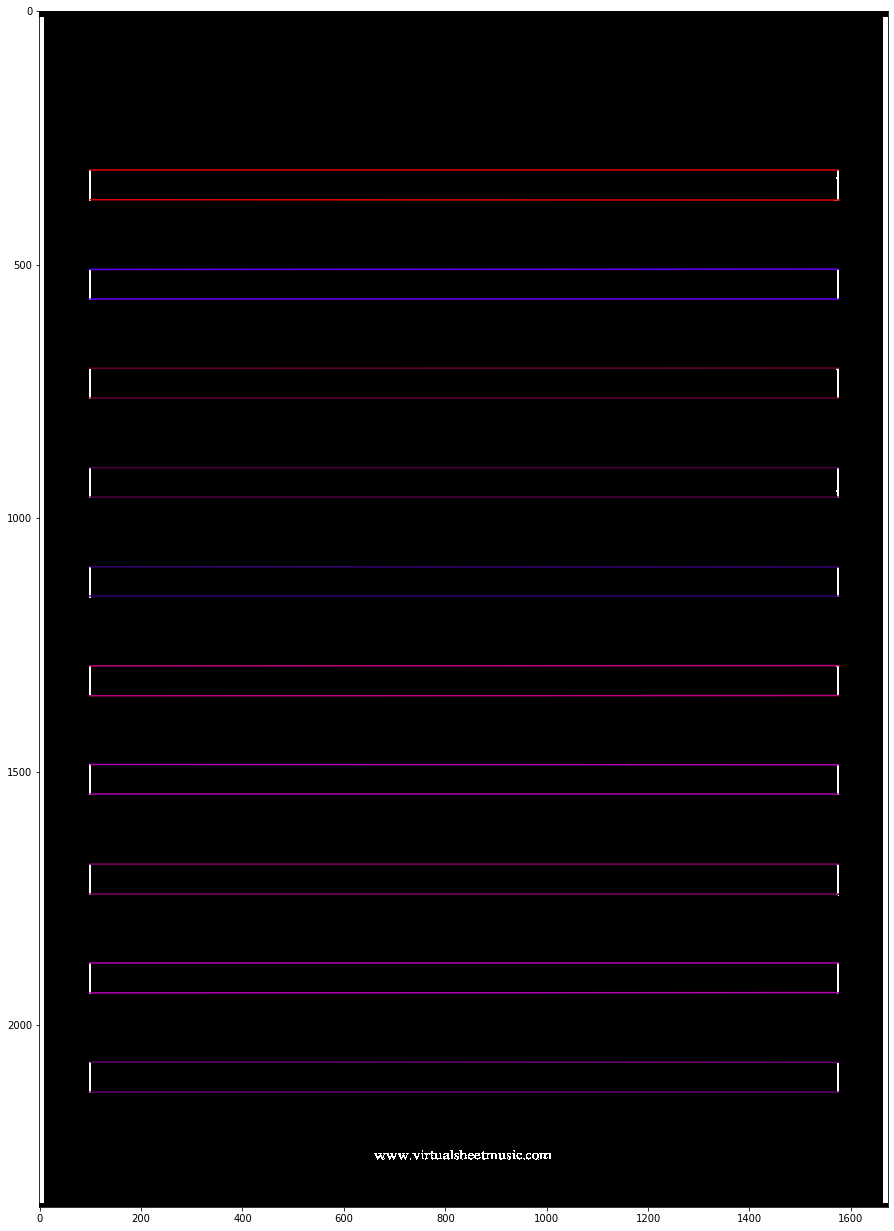

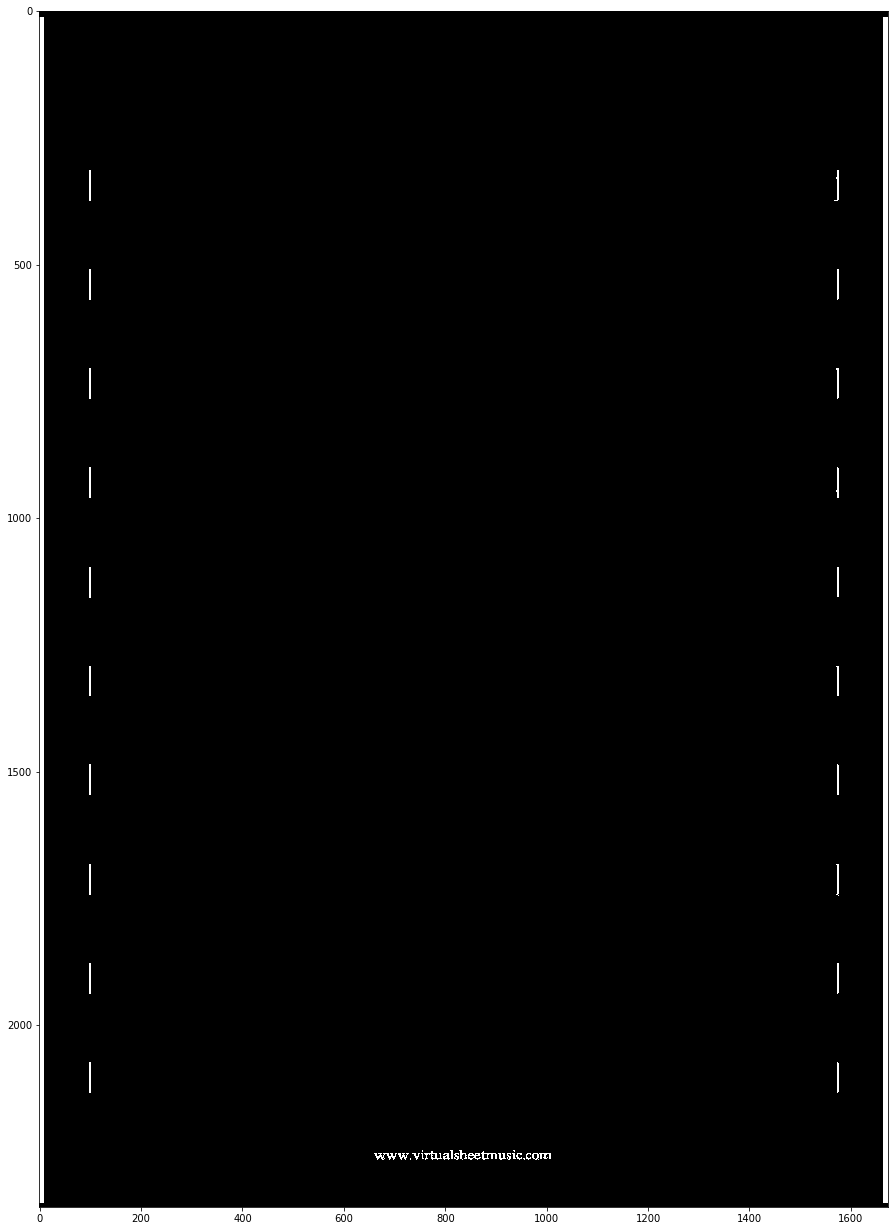

6.104360818862915

##############################   2   ##############################



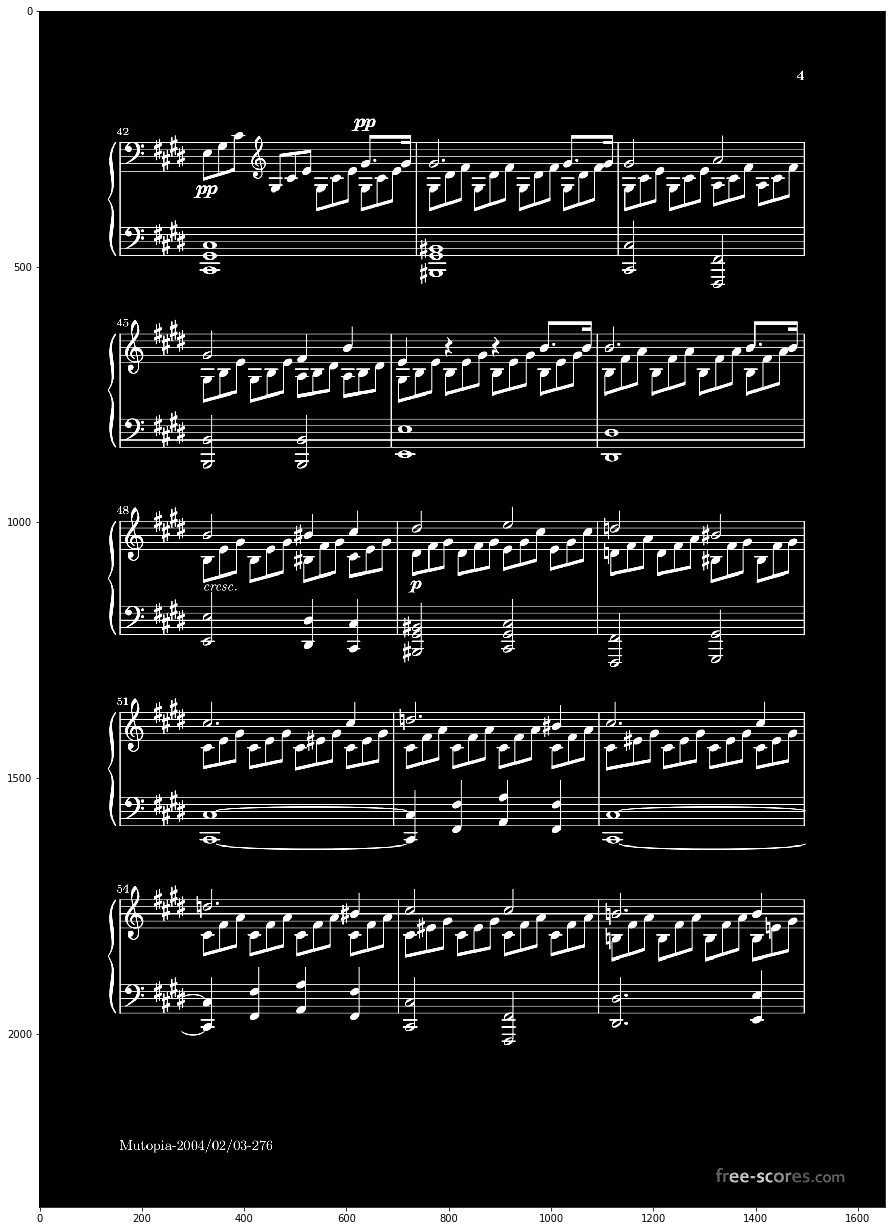

-0.25 24.73863375370596
-0.18 28.443016389131017
-0.01 100.00499987500625
0.0 51639.0
1.0 1081.0
2339 1653 0.0 0.0


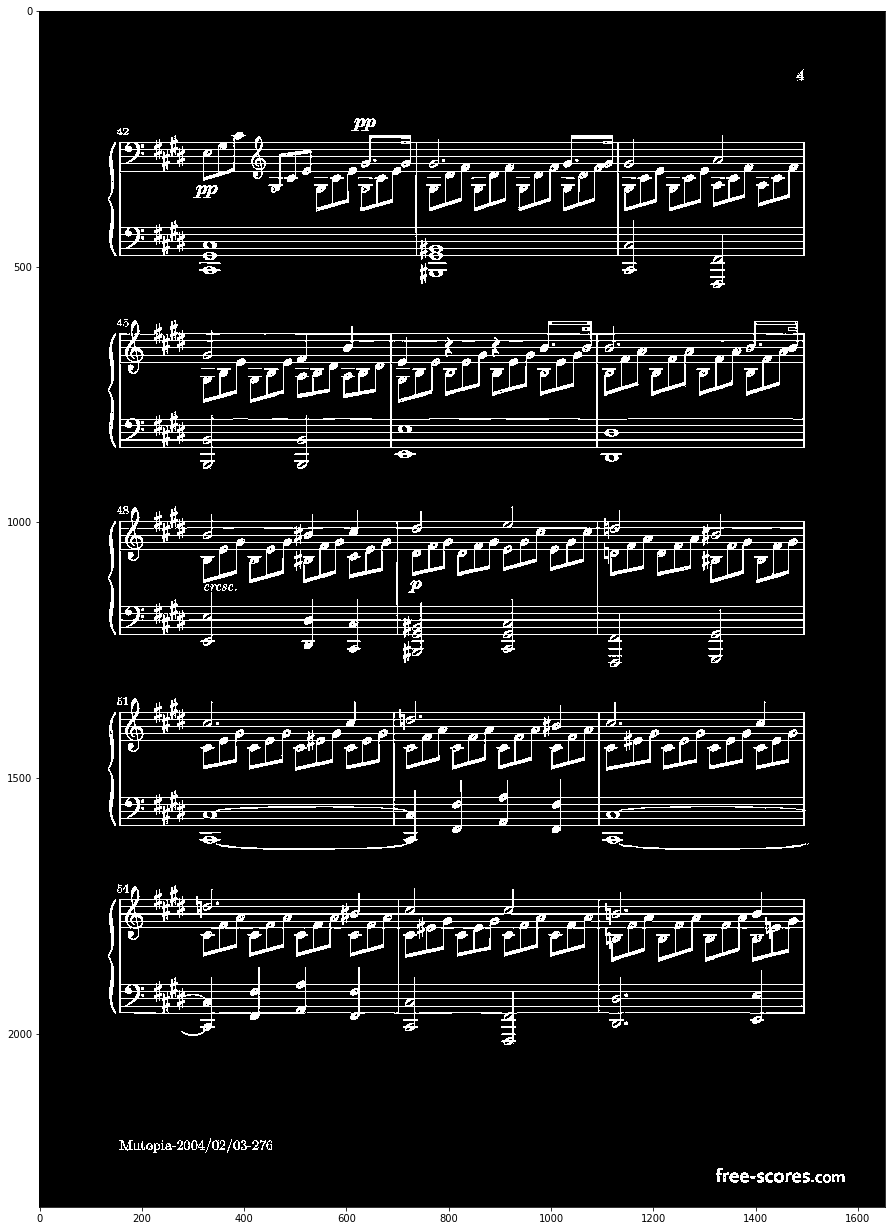

KeyboardInterrupt: 

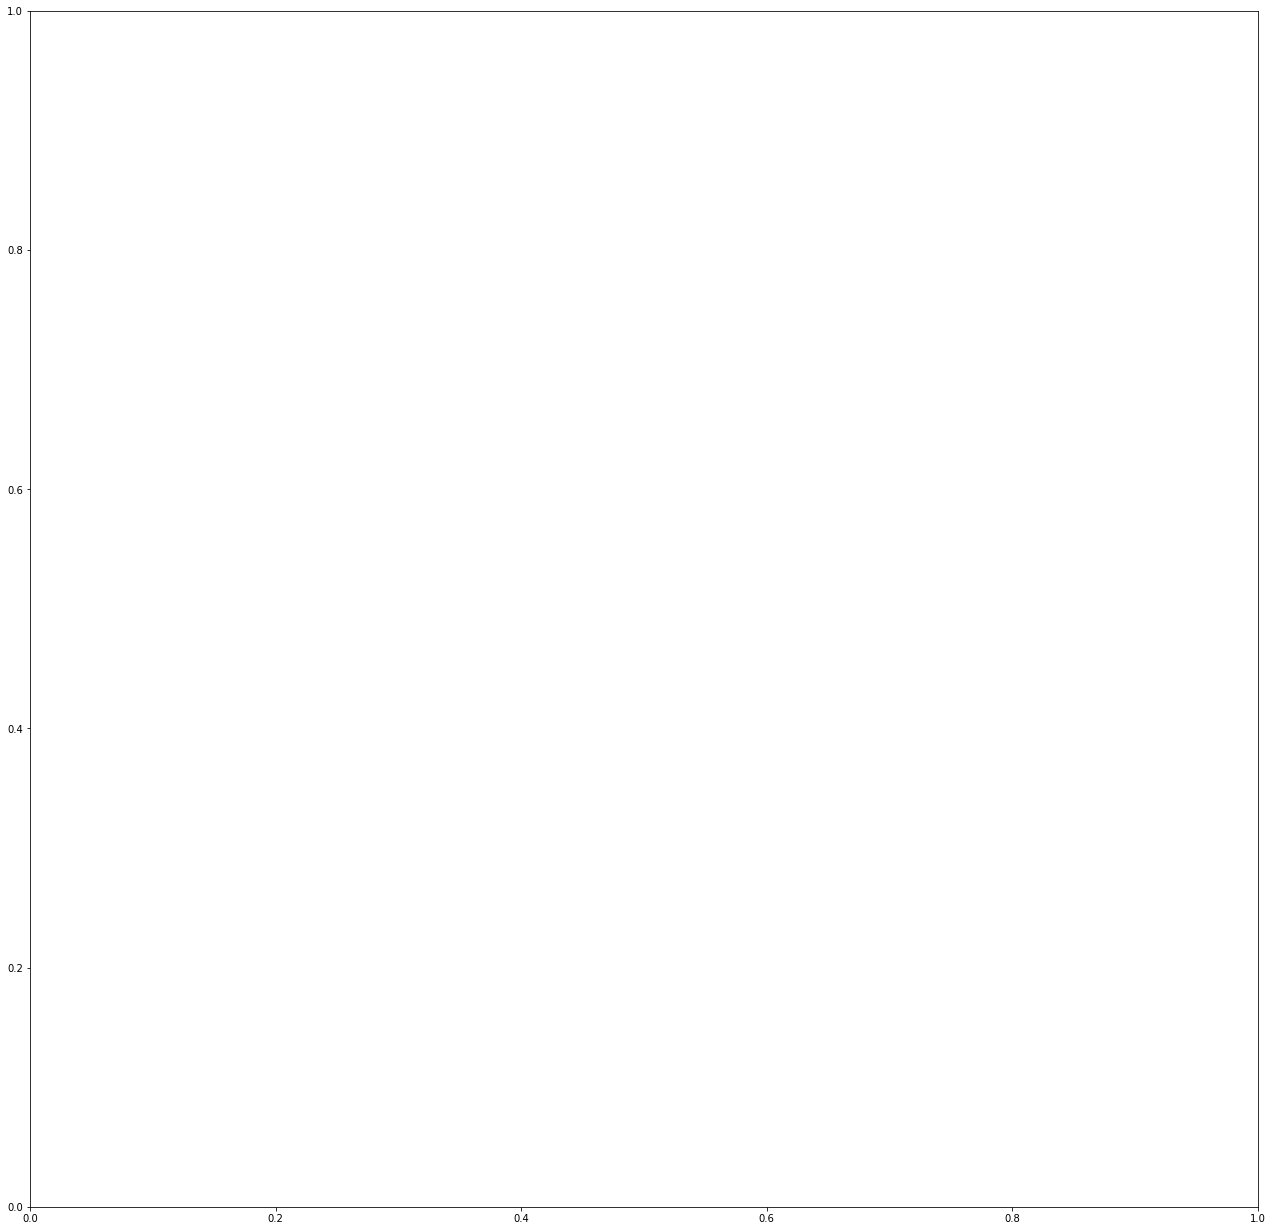

In [5]:
kernel=[0]*10
#kernele do grafiki
kernel[1]=np.asarray([[-1, -1, -1], [-1,8,-1], [-1, -1, -1]])
kernel[2]=np.asarray([[0, 1, 0], [1,-4,1], [0, 1, 0]])
kernel[3]=np.asarray([[0, 1, 0], [1,-5,1], [0, 1, 0]])
kernel[4]=(1/9)*np.asarray([[1, 1, 1], [1,1,1], [1, 1, 1]])
kernel[5]=(1/16)*np.asarray([[1, 2, 1], [2,4,2], [1, 2, 1]])
kernel[6]=(1/256)*np.asarray([[1,4,6,4,1], [4,16,24,16,4], [6,24,36,24,6], [4,16,24,16,4], [1,4,6,4,1]])
dm=(5,5)
kernel[7]=np.asarray([[1 for j in range(dm[0])] for i in range(dm[1])])
kernel[8]=np.asarray([[0, -1, 0], [-1,5,-1], [0, -1, 0]])

def binarization(bwimg):
    edges = cv.Canny(bwimg,50,150,apertureSize = 3)
    edges=cv.filter2D(bwimg, -1, kernel[1])
    mg2=cv.filter2D(edges, -1, kernel[7])
    edges=cv.filter2D(bwimg, -1, kernel[2])
    mg3=cv.filter2D(edges, -1, kernel[7])
    #bwimg=cv.morphologyEx(bwimg, cv.MORPH_BLACKHAT, kernel[7])
    bwimg=cv.adaptiveThreshold(bwimg, 255, cv.ADAPTIVE_THRESH_GAUSSIAN_C, cv.THRESH_BINARY, 145, 1)
    bwimg[mg2+mg3<30]=255
    
    return bwimg


def rotate_image(img, fimg):
    #Useless
    minLineLength = 100
    maxLineGap = 10
    
    kern=(1/256)*np.asarray([[1,4,6,4,1], [4,16,24,16,4], [6,24,36,24,6], [4,16,24,16,4], [1,4,6,4,1]])
    #img2=cv.filter2D(img, -1, kernel[2])
    img2=img.copy()
    #img2=cv.filter2D(img2, -1, kernel[7])
    #img2=cv.filter2D(img2, -1, kernel[7])
    #img2=cv.filter2D(img2, -1, kernel[7])
    edges = cv.Canny(img2,50,150,apertureSize = 3)
    lines = cv.HoughLinesP(edges,1,np.pi/180,100,minLineLength,maxLineGap)
    
    #print(lines)
    if (lines is None):
        lines=[]
    cosa=[0]*len(lines)
    lenny=[0]*len(lines)
    for i, iv in enumerate(lines):
        x1,y1,x2,y2=iv[0]
        if (x2<x1 or (x2==x1 and y2<y1)):
            f1, f2=x1, y1
            x1, y1=x2, y2
            x2, y2=x1, y1
        
        dx, dy=(x2-x1), (y2-y1)
        
        if (dx*dx+dy*dy>0):
            cosa[i]=dy/math.sqrt(dy*dy+dx*dx)
        else:
            cosa[i]=0
        lenny[i]=math.sqrt(dy*dy+dx*dx)
        cv.line(img,(x1,y1),(x2,y2),(255,0,0),1)
    
    x=0
    blyat=[0]*210
    for i in range(len(cosa)):
        s=math.floor(cosa[i]*100)+100
        blyat[s]+=lenny[i]
        if (blyat[s]>blyat[x]):
            x=s
    x=(x-100)/100
    
    
    
    #print(cosa, x)
    for i, v in enumerate(blyat):
        if (v>5):
            print((i-100)/100, v)
    
    
        
    angle=90-math.acos(x)*(180/math.pi)
    
    h, w = img.shape[:2]
    print(h, w, angle, x)
    image_center = (w/2, h/2)

    rotation_mat = cv.getRotationMatrix2D(image_center, angle, 1)

    radians = math.radians(angle)
    sin = math.sin(radians)
    cos = math.cos(radians)
    bound_w = int((h*abs(sin)) + (w*abs(cos)))
    bound_h = int((h*abs(cos)) + (w*abs(sin)))

    rotation_mat[0, 2] += ((bound_w / 2) - image_center[0])
    rotation_mat[1, 2] += ((bound_h / 2) - image_center[1])

    rotated_mat = cv.warpAffine(img, rotation_mat, (bound_w, bound_h), borderValue=255)
    """
    kgbo=np.zeros((img.shape[0], img.shape[1], 3), dtype='uint8')
    kgbo[:,:,0]=img
    kgbo[:,:,1]=img
    kgbo[:,:,2]=img
        
    for i, iv in enumerate(lines):
        x1,y1,x2,y2=iv[0]
        dx, dy=(x2-x1), (y2-y1)

        cosa[i]=abs(dy)/math.sqrt(dy*dy+dx*dx)    
        cv.line(kgbo,(x1,y1),(x2,y2),(255,0,0),1)
        
    grave(kgbo)
    """
    return rotated_mat



C=100000
par=list(range(C))
rank=[0]*C
great_dis=[0]*C

def make_set(i):
    par[i]=i
    rank[i]=0
    great_dis[i]=0

def find_par(a):
    if (a!=par[a]):
        par[a]=find_par(par[a])
    return par[a]


def union(x, y, v):
    a=find_par(x)
    b=find_par(y)
    
    great_dis[a]=max(great_dis[a], great_dis[b], v)
    great_dis[b]=max(great_dis[a], great_dis[b], v)
    if (rank[a]<rank[b]):
        par[a]=b
    else:
        par[b]=a
    if (rank[a]==rank[b]):
        rank[a]+=1
    
def petrify(path, axe):
    #kgbo=np.zeros((img.shape[0], img.shape[1], 3), dtype='uint8')
    #kgbo[:,:,0]=img
    #kgbo[:,:,1]=img
    #kgbo[:,:,2]=img
    #ax.imshow(kgbo)
    for i in range(len(path)):
        ax.scatter(path[i][1], path[i][0], color='red')
    
    #plt.show()



for i in range(j):
    t1=time.time()
    decorate(i)
    imgb=f[i].copy()
    grave(imgb, 1)
    shorig=imgb.shape
    
    ###BINARIZATION
    imv=binarization(imgb)
    #Rotacja po linii - czasem jeszcze nie działa
    img2=rotate_image(imv, imgb)
    grave(img2, 1)
    
    
    
    ss=np.zeros((img2.shape[0]+20, img2.shape[1]+20), dtype=str(img2.dtype))
    ss[10:-10,10:-10]=img2
    img2=ss.copy()
    
    
    ###DETECTION
    fig, ax=plt.subplots(1,1,figsize=(22,22)) 
    sol=findlinez(img2, shorig)
    #sol - lista tupli - 1-wszy to uśrednione miejsce linii pięciolinii, 2-gi to grubość linii
    
    dp=[0]*len(sol)
    kenose=[0]*len(sol)
    tv=[0]*len(sol)
    for i, x in enumerate(sol):
        make_set(i)
        if (i>0):
            dp[i]=sol[i][0]-sol[i-1][0]
            tv[i]=i
            
    vv=zip(dp,tv)
    vv=sorted(vv, key=lambda x:x[0])
    dp, tv=tuple(zip(*list(vv)))
    for i, x in enumerate(dp):
        if (dp[i]<6 or ((2*great_dis[find_par(tv[i]-1)]>dp[i] or great_dis[find_par(tv[i]-1)]<6) and (2*great_dis[find_par(tv[i])]>dp[i] or great_dis[find_par(tv[i])]<6))):
            union(tv[i], tv[i]-1, dp[i])
            
    
    
    print('kolejno: [xbl, xbr], [ybl, ybr], [xel, xer], [yel, yer]')
    print('x - ixowa, y - ygrekowa, b - 1. linia, e - ostatnia linia, l - lewo, r - prawo')
    cl=(1, 0, 0)
    chan=0
    outer=[0]*len(sol)
    wynne=[]
    for i in range(len(sol)):
        if (i>0 and find_par(i)!=find_par(i-1)):
            chan=chan+1
        outer[chan]+=1
    
    chan=0
    xlm, xrm, yb, ye=100000, 0, 0, 0
    vb=sol[0][4]
    for i, x in enumerate(sol):
        if (i>0 and find_par(i)!=find_par(i-1)):
            ye=sol[i-1][0]
            ve=sol[i-1][4]
            if (outer[chan]>=3 and outer[chan]<=15):
                #ax.axhline(yb, color=cl)
                #ax.axhline(ye, color=cl)
                dtrl, dtrr=20, 60
                ax.plot([vb[1][1], vb[-1][1]], [sum(list(zip(*vb))[0][dtrl:dtrr])/(dtrr-dtrl), sum(list(zip(*vb))[0][-dtrr:-dtrl])/(dtrr-dtrl)], color=cl)
                ax.plot([ve[1][1], ve[-1][1]], [sum(list(zip(*ve))[0][dtrl:dtrr])/(dtrr-dtrl), sum(list(zip(*ve))[0][-dtrr:-dtrl])/(dtrr-dtrl)], color=cl)
                
                #petrify(vb, ax)
                #petrify(ve, ax)
                #wynne teraz zawiera 4 listy, kolejno: [xbl, xbr], [ybl, ybr], [xel, xer], [yel, yer]
                #x - ixowa, y - ygrekowa, b - 1. linia, e - ostatnia linia, l - lewo, r - prawo
                wynne.append(([vb[1][1], vb[-1][1]], [sum(list(zip(*vb))[0][dtrl:dtrr])/(dtrr-dtrl), sum(list(zip(*vb))[0][-dtrr:-dtrl])/(dtrr-dtrl)], [ve[1][1], ve[-1][1]], [sum(list(zip(*ve))[0][dtrl:dtrr])/(dtrr-dtrl), sum(list(zip(*ve))[0][-dtrr:-dtrl])/(dtrr-dtrl)]))
            
            cl=(random.random(), 0, random.random())
            chan=chan+1
            xlm=100000
            xrm=0
            yb=x[0]
            vb=x[4]
        xlm=min(xlm, x[2])
        xrm=max(xrm, x[3])
        
    #TU MASZ WYNIKI
    for x in wynne:
        print(x)
    
    print('liczba liń z pięcioliń: {} (jak podzielna przez 5 to pewnie się zgadza)'.format(len(sol)))
    
    
    ax.imshow(img2, cmap='Greys',  interpolation='nearest')
    plt.show()
    
    grave(img2, 1)
    t2=time.time()
    print(t2-t1)
    

In [ ]:
#### 

In [ ]:
###Śmieci do recyklingu



##Bardzo efektywny do pdfów
kernel=[0]*10
#kernele do grafiki
kernel[1]=np.asarray([[-1, -1, -1], [-1,8,-1], [-1, -1, -1]])
kernel[2]=np.asarray([[0, 1, 0], [1,-4,1], [0, 1, 0]])
kernel[3]=np.asarray([[0, 1, 0], [1,-5,1], [0, 1, 0]])
kernel[4]=(1/9)*np.asarray([[1, 1, 1], [1,1,1], [1, 1, 1]])
kernel[5]=(1/16)*np.asarray([[1, 2, 1], [2,4,2], [1, 2, 1]])
kernel[6]=(1/256)*np.asarray([[1,4,6,4,1], [4,16,24,16,4], [6,24,36,24,6], [4,16,24,16,4], [1,4,6,4,1]])
dm=(7,7)
kernel[7]=np.asarray([[1 for j in range(dm[0])] for i in range(dm[1])])
kernel[8]=np.asarray([[0, -1, 0], [-1,5,-1], [0, -1, 0]])


for i in range(j):
    img=f[i].copy()
    grayscaled = cv.cvtColor(img,cv.COLOR_BGR2GRAY)
    img2=cv.adaptiveThreshold(grayscaled, 255, cv.ADAPTIVE_THRESH_GAUSSIAN_C, cv.THRESH_BINARY, 35, 1)
    grave(img2)
    grave(img)
    
    
    
    
#To idzie do lamusa
def detect_5(bwimg):
    cs=0
    jj=0
    bethon=[0]*1000
    x=0
    cdis=80
    v1, v2=10, cdis+10
    
    while (x<len(bwimg)-v1):
        svv=((255-bwimg[x:x+cdis,:])//255).astype('int32')
        svg=(sorted(np.sum(svv, axis=1), reverse=1))
        stv=zip(range(x, x+cdis), np.sum(svv, axis=1))
        stv=(sorted(stv, key=lambda x:x[1], reverse=1))
        
        svv2=((255-bwimg[x+v1:x+v2,:])//255).astype('int32')
        svg2=(sorted(np.sum(svv2, axis=1), reverse=1))
        stv2=zip(range(x+v1, x+v2), np.sum(svv2, axis=1))
        stv2=(sorted(stv2, key=lambda x:x[1], reverse=1))
        
        #Ta heura na razie jest koszmarna i nieuniwersalizowalna, choć idea pewnie dobra
        if (len(svg2)>5 and svg[4]==svg2[4] and svg[4]>0.6*bwimg.shape[1] and distinct(stv)==1):
            bethon[jj]=(x+5, x+cdis+5, stv2[:15])
            jj+=1
            x+=cdis
        else:
            x+=1
    return (bethon[:jj])


#Bierze imidż zarotowany równolegle do górnej krawędzi obrazka
def distinct(arr):
    st=sorted(arr, key=lambda x:x[0])
    j=0
    dist=1
    while (j<len(arr)):
        if (0.8*arr[0][1]>arr[j][1]):
            break
        if (j>0 and arr[j][0]-arr[j-1][0]>3):
            dist+=1
        j+=1
    return (1 if dist>=5 else 0)



    
    
    
    kgbo=np.zeros((img.shape[0], img.shape[1], 3), dtype='uint8')
    kgbo[:,:,0]=img
    kgbo[:,:,1]=img
    kgbo[:,:,2]=img
        
    for i, iv in enumerate(lines):
        x1,y1,x2,y2=iv[0]
        dx, dy=(x2-x1), (y2-y1)

        cosa[i]=abs(dy)/math.sqrt(dy*dy+dx*dx)    
        cv.line(kgbo,(x1,y1),(x2,y2),(255,0,0),1)
        
    grave(kgbo)
    
    """
            for i,x in enumerate(pathway):
                if (i==0):
                    continue
                if (bwimg[pathway[i][0],pathway[i][1]]==255):
                    if (bwimg[pathway[i-1][0],pathway[i][1]]==0):
                        pathway[i][0]=pathway[i-1][0]
                    else:
                        tv=pathway[i][0]
                        while (bwimg[tv, pathway[i][1]]==255):
                            tv=tv+jj
                            jj=-jj-1*jj//abs(jj)                             
                        cur-=1
            """

In [42]:
c=[(1,2),(3,4),(5,6)]
print(np.asarray(c))

[[1 2]
 [3 4]
 [5 6]]


In [29]:
%%cython
import numpy as np
import math
cimport numpy as np
from cpython cimport array
import array


def blackening(np.ndarray[unsigned char, ndim=2] bwimg, np.ndarray[int, ndim=2] path):
    cdef int s=0, t=0, gr=0, ij, i, jj
    cdef np.ndarray[int, ndim=1] dep=np.zeros((len(path)), dtype='int32')
    cdef np.ndarray[int, ndim=1] end1=np.zeros((len(path)), dtype='int32')
    cdef np.ndarray[int, ndim=1] end2=np.zeros((len(path)), dtype='int32')
    
    for i in range(0, len(path)):
        for ij in range(0, -10, -1):
            a, b=path[i][0]+ij, path[i][1]
            if (bwimg[a,b]==255):
                break
        end1[i]=ij
        
        for ij in range(1, 10, 1):
            a, b=path[i][0]+ij, path[i][1]
            
            if (bwimg[a,b]==255):
                break
        end2[i]=ij
        
        dep[i]=end2[i]-end1[i]
    ld=len(dep)
    dep2=sorted(dep)
    small=dep2[math.floor(0.1*ld)]
    large=dep2[math.floor(0.9*ld)]
    
    dep2=dep2[math.floor(0.1*ld):math.floor(0.9*ld)]
    grub=sum(dep2)/len(dep2)-2
    #print('DEPTH {} {}'.format(grub, dep))
    
    midian=[0]*len(path)
    cur=0
    last=0
    midian[0]=path[0][0]
    for i in range(1, len(path)):
        if (dep[i]>grub+3):
            cur+=1
            continue
        else:
            midian[i]=path[i][0]+(end2[i]+end1[i])//2
            while (cur>0):
                p=path[i][0]-cur
                midian[i-cur]=midian[i] if (cur<p-last) else midian[last]
                tv=midian[i-cur]
                jj=1
                while (bwimg[tv, path[i-cur][1]]==255):
                    tv=tv+jj
                    jj=-jj-1*jj//abs(jj) 
                midian[i-cur]=tv
                cur-=1
            last=i
            
    #print(list(zip(path, midian)))
    dt0=math.ceil(grub)
    for i in range(len(path)):
        sc, t1, t2=0, 0, 0
        for jj in range(1, 10):
            if (bwimg[midian[i]+jj, path[i][1]]==255):
                break
        t1=jj
        for jj in range(0, -10, -1):
            if (bwimg[midian[i]+jj, path[i][1]]==255):
                break
        t2=jj
        sc=t1-t2
        
        if (sc<=dt0+3):
            for jj in range(t2, t1+1, 1):
                bwimg[midian[i]+jj, path[i][1]]=255
    c1=math.floor(0.1*len(midian))
    c2=math.floor(0.9*len(midian))
    
    return (sum(midian[c1:c2])/len(midian[c1:c2]), grub)


def cleanblack(bwimg, pathway):
    for x in pathway:
        bwimg[x[0]-2:x[0]+2,x[1]]=255
    return (1,2)

#limit - o ile y może się odchylić od y2
def pathfinder(np.ndarray[unsigned char, ndim=2] bwimg, np.ndarray[int, ndim=2] F, np.ndarray[unsigned char, ndim=2] check, np.ndarray[int, ndim=1] par, np.ndarray[int, ndim=1] w, awp, awm, int y, int x, int p, int vv, int lowx, int highx, int y2, np.ndarray[int, ndim=1] miss):
    cdef int limit=30, l2=6
    
    if (y>=bwimg.shape[0] or x>=bwimg.shape[1] or x<0 or y<0 or abs(y-y2)>limit):
        return (p, lowx, highx)
    if (check[y,x]==0 and (bwimg[y,x]==0 or miss[vv]<l2)):
        if (bwimg[y,x]==255):
            miss[p]=miss[vv]+1
        else:
            miss[p]=0
        F[p,0]=y
        F[p,1]=x
        check[y,x]=1
        par[p]=vv
        if (x<lowx):
            lowx=x
            awm.append(p)
            w[p]=-1
        elif (x>highx):
            highx=x
            awp.append(p)
            w[p]=1
        else:
            w[p]=0
        return (p+1, lowx, highx)
    return (p, lowx, highx)


def findlinez(np.ndarray[unsigned char, ndim=2] bwimg, shp):
    cdef int skv=2, y=1, kk=1, iF=0, jF=1, deadl=0, deadr=1, highx, lowx, x1, x2, conn=1000, C=100000
    solution=[]
    cdef np.ndarray[unsigned char, ndim=2] check=np.zeros((bwimg.shape[0], bwimg.shape[1]), dtype='uint8')
    cdef np.ndarray[int, ndim=1] par=np.zeros((C), dtype='int32')
    cdef np.ndarray[int, ndim=1] miss=np.zeros((C), dtype='int32')
    cdef np.ndarray[int, ndim=1] w=np.zeros((C), dtype='int32')
    
    cdef np.ndarray[int, ndim=2] F=np.zeros((C, 2), dtype='int32')
    #cdef np.ndarray[int, ndim=1] pathway=np.zeros((C), dtype='int32')
    
    for kk in range(1, skv):
        y=1
        x1=(kk*bwimg.shape[1])//skv-2
        x2=(kk*bwimg.shape[1])//skv+2
        
        while (y<bwimg.shape[0]-1):
            vs=bwimg[y,x1:x2+1]
            if (0 in vs):
                xl=kk*(bwimg.shape[1]//skv)
                yl=y
                
                pathway=[]
                
                F[0,0]=yl
                F[0,1]=xl
                
                par[0]=-1
                w[0]=0
                awp=[]
                awm=[]
                miss[0]=0
                
                highx, lowx=xl, xl
                deadl, deadr=0, 0
                pointdead=[0,0]
                iF, jF=0, 1
                conn=1000
                
                while(iF<jF):
                    s=F[iF]
                    jF, lowx, highx=pathfinder(bwimg, F, check, par, w, awp, awm, s[0]-1, s[1], jF, iF, lowx, highx, y, miss)
                    jF, lowx, highx=pathfinder(bwimg, F, check, par, w, awp, awm, s[0]+1, s[1], jF, iF, lowx, highx, y, miss)
                    jF, lowx, highx=pathfinder(bwimg, F, check, par, w, awp, awm, s[0], s[1]-1, jF, iF, lowx, highx, y, miss)
                    jF, lowx, highx=pathfinder(bwimg, F, check, par, w, awp, awm, s[0], s[1]+1, jF, iF, lowx, highx, y, miss)
                    
                    if (len(awp)>4 and awp[-5]<jF-conn and deadr==0):
                        deadr=1
                        pointdead[1]=jF-conn
                    if (len(awm)>4 and awm[-5]<jF-conn and deadl==0):
                        deadl=1
                        pointdead[0]=jF-conn
                    if (deadl==1 and deadr==1):
                        break
                    iF+=1
                if (pointdead[0]==0):
                    pointdead[0]=jF-1
                if (pointdead[1]==0):
                    pointdead[1]=jF-1
                #print(y, jF, lowx, highx)
                #print('PedE', pointdead, jF, highx, lowx)
                j1=pointdead[0]
                for j1 in range(pointdead[0], -1, -1):
                    if (w[j1]==-1 and bwimg[F[j1][0], F[j1][1]]==0):
                        break
                while (j1>=0):
                    pathway.append((F[j1,0],F[j1,1]))
                    j1=par[j1]
                
                j2=pointdead[1]
                for j2 in range(pointdead[1], -1, -1):
                    if (w[j2]==1 and bwimg[F[j2][0], F[j2][1]]==0):
                        break
                
                p2=[]
                while (j2>0):
                    p2.append((F[j2,0],F[j2,1]))
                    j2=par[j2]
                
                pathway.extend(p2[::-1])
                for j in range(jF):
                    check[F[j,0], F[j,1]]=0
                
                if (highx-lowx>shp[1]*0.15):
                    sv, gr=blackening(bwimg, np.asarray(pathway))
                    #sv, gr=cleanblack(bwimg, pathway)
                    solution.append((sv, gr, lowx, highx))
            y+=1
    return solution

In [33]:
tt=[(1,2),(3,4),(5,6),(7,8)]
print(list(zip(*tt))[0][-3])

3
